In [456]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML tools
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [457]:
# Load dataset
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

# Preview the data
df_astro.head()

,E_peak,beta,sigma,beta_Rel,"0,1=astro,DM"
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [458]:
# Rename the weird column header for clarity
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})

# Preview the structure
print(df_astro.columns)

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


In [459]:
df_astro.describe()

,E_peak,beta,sigma,beta_Rel,class
count,2831.000000,2831.000000,2831.000000,2831.000000,2831.0
mean,-0.086668,-0.935025,1.112434,-0.219436,0.0
std,1.280269,0.425847,0.370543,0.447146,0.0
min,-5.912006,-2.602060,0.609189,-3.198657,0.0
25%,-0.683526,-1.190440,0.819636,-0.431508,0.0
50%,0.008004,-0.935917,1.037837,-0.185014,0.0
75%,0.689384,-0.643496,1.328710,0.026877,0.0
max,5.918502,0.000000,2.899104,1.629309,0.0


## Visualization of Data

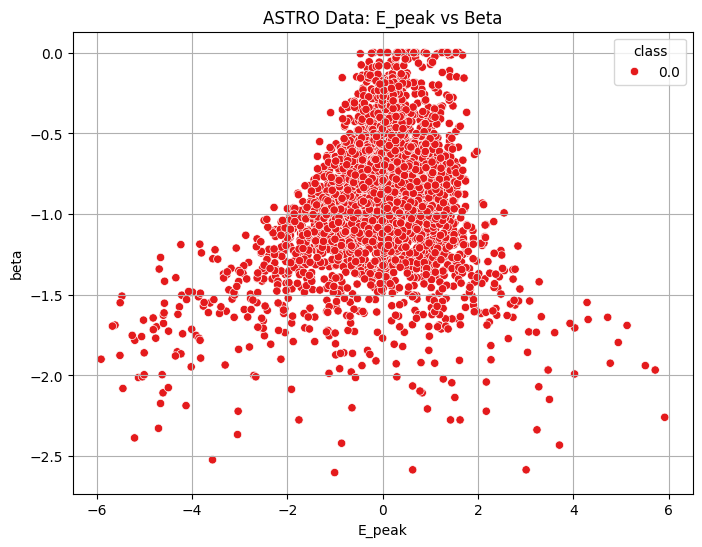

In [460]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_astro, x="E_peak", y="beta", hue="class", palette="Set1")
plt.title("ASTRO Data: E_peak vs Beta")
plt.grid(True)
plt.show()

# Split data into Training and Testing (Within ASTRO) - Check distribution of both sets

In [461]:
from sklearn.model_selection import train_test_split

X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

Check training and testing data:

In [462]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1981, 2)
X_test shape: (850, 2)


In [463]:
# Convert to DataFrame for better readability
pd.DataFrame(X_train, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.630042,-0.346807
1,-0.894831,-0.480750
2,-0.321118,-0.029960
3,-0.473919,-0.444156
4,-0.849244,-0.411235


In [464]:
pd.DataFrame(X_test, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.656198,0.836172
1,-0.960586,0.292411
2,-0.841035,-1.483399
3,-0.716925,-0.747560
4,-1.128427,0.383869


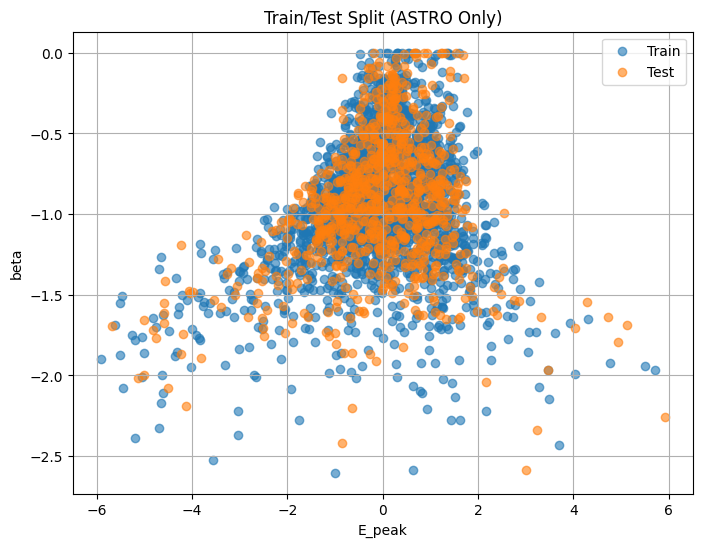

In [465]:

# Quick Scatter Plot to double-check the distribution after splitting:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 1], X_train[:, 0], label='Train', alpha=0.6)
plt.scatter(X_test[:, 1], X_test[:, 0], label='Test', alpha=0.6)
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Train/Test Split (ASTRO Only)")
plt.legend()
plt.grid(True)
plt.show()

# OneClassSVM Model - training

In [466]:
from sklearn.svm import OneClassSVM

# Initialize the model
clf = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')

# train the model
clf.fit(X_train)

OneClassSVM(nu=0.01)

# Visualize "learned" frontier of the trained model

In [467]:
import numpy as np
import matplotlib.pyplot as plt

# Create a meshgrid over the feature space
xx, yy = np.meshgrid(
    np.linspace(X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5, 300)   # beta
)

# Stack into grid shape for prediction
grid = np.c_[yy.ravel(), xx.ravel()]  # Notice: beta first, then E_peak to match feature order
Z = clf.decision_function(grid)  # Get decision function values
Z = Z.reshape(xx.shape)

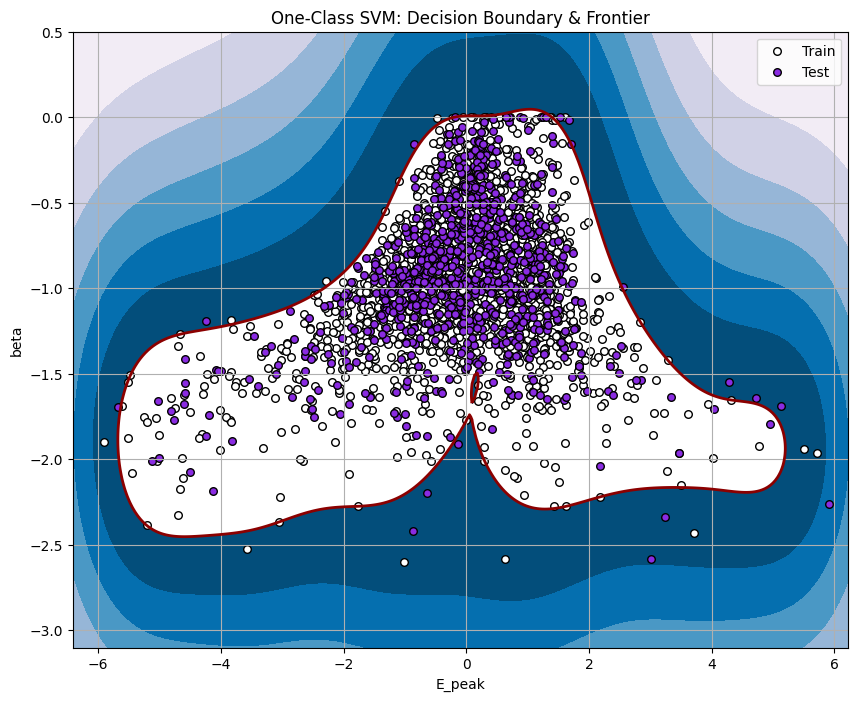

In [468]:
plt.figure(figsize=(10, 8))

# Filled contour of decision function (the 'heatmap')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # The learned frontier

# Plot training and test data
plt.scatter(X_train[:, 1], X_train[:, 0], c='white', edgecolors='k', s=30, label="Train")
plt.scatter(X_test[:, 1], X_test[:, 0], c='blueviolet', edgecolors='k', s=30, label="Test")

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM: Decision Boundary & Frontier")
plt.legend()
plt.grid(True)
plt.show()

# Make Predictions

In [ ]:
# make predictions
# +1 = inlier, -1 = outlier
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


In [ ]:
# Evaluate results of trained model

n_error_train = (y_pred_train == -1).sum()
# n_error_train = y_pred_train[y_pred_train == -1].size

n_error_test = (y_pred_test == -1).sum()
# n_error_test = y_pred_test[y_pred_test == -1].size

print(f"Training errors (outliers): {n_error_train}/{len(X_train)}")
print(f"Testing errors (outliers): {n_error_test}/{len(X_test)}")

Training errors (outliers): 16/1981
Testing errors (outliers): 15/850


## Visualize Predictions Results

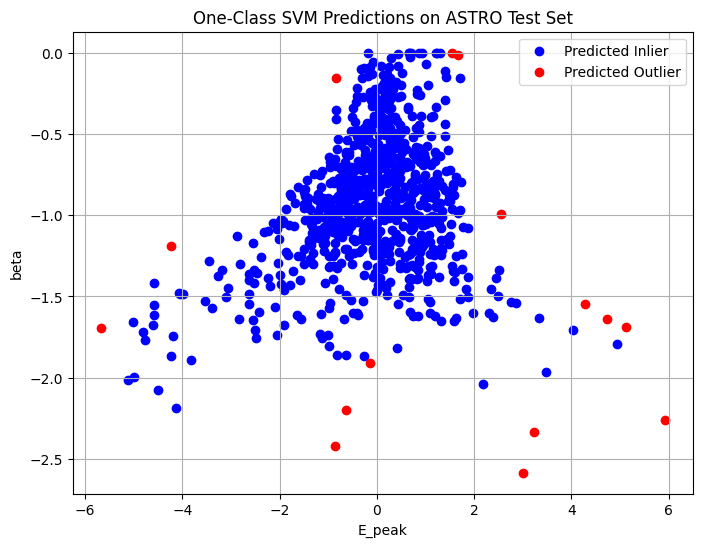

In [471]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot normal predictions
plt.scatter(X_test[y_pred_test == 1, 1], X_test[y_pred_test == 1, 0], c="blue", label="Predicted Inlier")

# Plot predicted outliers
plt.scatter(X_test[y_pred_test == -1, 1], X_test[y_pred_test == -1, 0], c="red", label="Predicted Outlier")

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM Predictions on ASTRO Test Set")
plt.legend()
plt.grid(True)
plt.show()

Decision Function / Scoring

In [472]:
scores = clf.decision_function(X_test)  # Higher = more normal